## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [30]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [31]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

n = 10000
lift = 1.01

x = np.random.exponential(size=n)
y = np.random.exponential(size=n) * lift

df = pd.DataFrame({"x": x, "y": y})

  0%|          | 0/2000 [00:00<?, ?it/s]

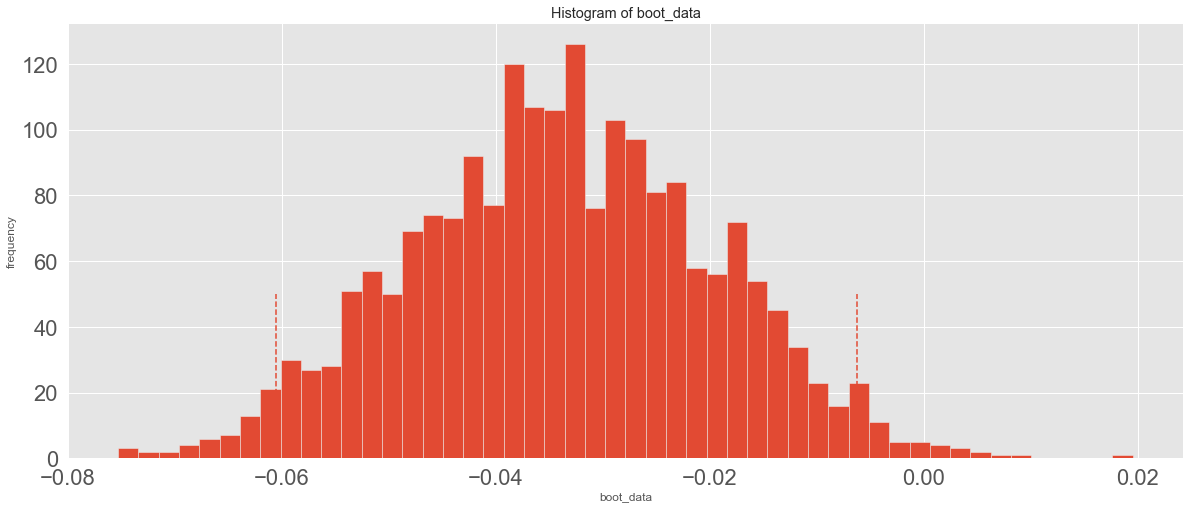

In [32]:
booted_data = get_bootstrap(df.x, df.y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [5]:
booted_data["p_value"]

0.015967841910844854

In [6]:
booted_data["ci"]

,0
0.025,-0.060541
0.975,-0.006225


## Применим бутстрап на реальных данных
Имеется таблица, где числовая переменная – непрерывная.
Сравним группы двумя способами: бутстрапом и u-тестом

In [1]:
#Импортируем seaborn для визуализации
import seaborn as sns

In [2]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,8)}
        )
#Определяем настройки отображения графиков

In [5]:
#Загрузим датафрейм
boot_df = pd.read_csv('C:/Users/79256/Github/Data_Analyse/Data/data for bootstrap.csv', sep=';')

In [6]:
#Посмотрим на данные
boot_df.head(10)

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
5,6,"8,73578048192978",Control
6,7,"10,7806383791004",Control
7,8,"11,1393983918781",Control
8,9,"10,0675199319953",Control
9,10,"9,53130741186623",Control


In [47]:
boot_df.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [7]:
#Проверим типы данных(видим тип object у колонки value)
boot_df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [8]:
#Подготовим колонку value  к анализу. Изменим запятую на точку и поменяем тип данных
boot_df['value'] = boot_df['value'].str.replace(',','.') \
                                    .apply(pd.to_numeric)

In [9]:
#Проверим результат
boot_df.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [20]:
#Сформируем для анализа датасеты колонки value, разделенные на контроль/тест
df_test = boot_df.query('experimentVariant == "Treatment"')
df_control = boot_df.query('experimentVariant == "Control"')

<AxesSubplot:xlabel='value'>

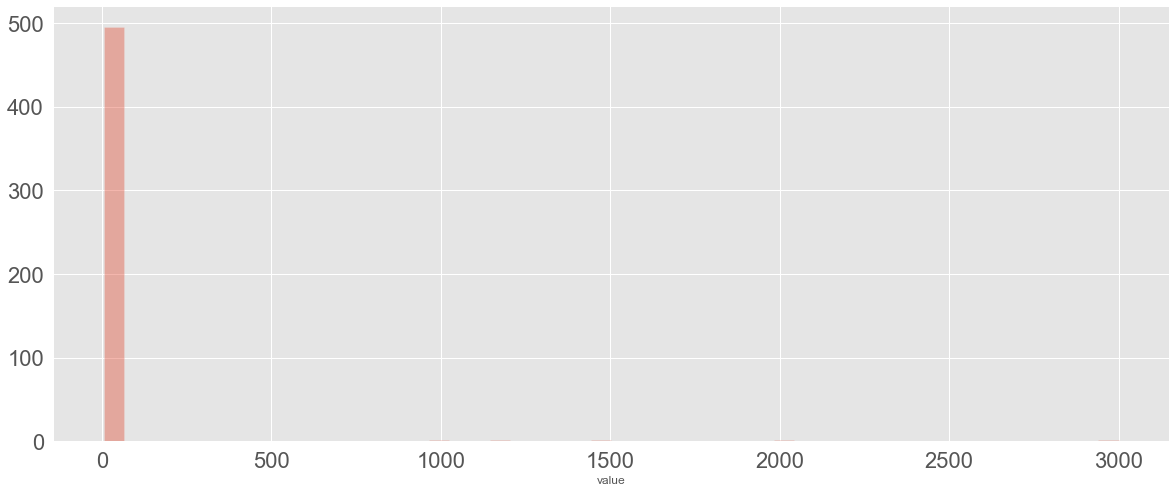

In [24]:
#Построим распределение данных по группам,видим большие выбросы в тестовой группе
sns.distplot(df_test.value,kde=False)

<AxesSubplot:xlabel='value'>

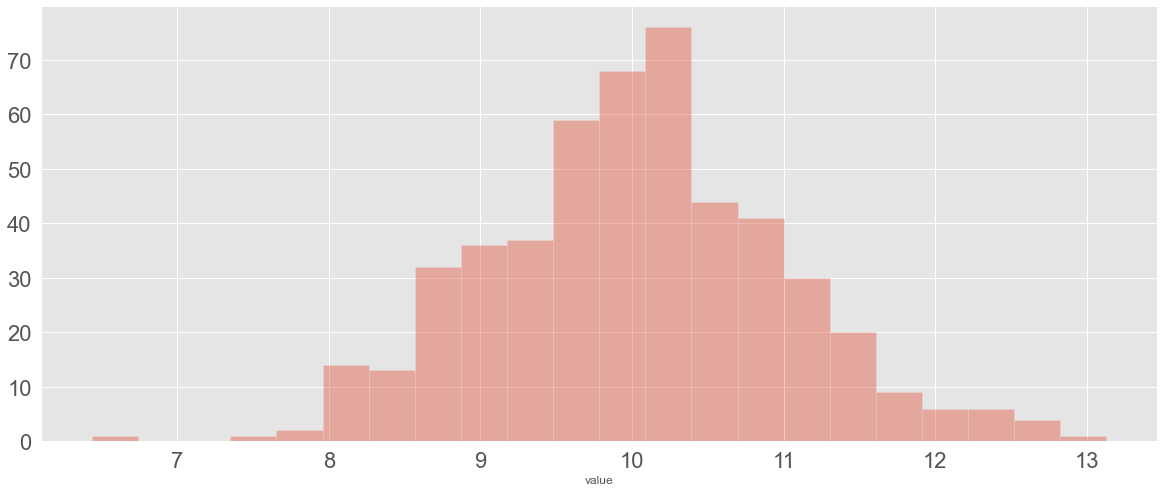

In [25]:
sns.distplot(df_control.value,kde=False)

In [ ]:
#Применим бутстрап на основе среднего и медианного значения подвыборок, а также критерий Манна-Уитни.

  0%|          | 0/2000 [00:00<?, ?it/s]

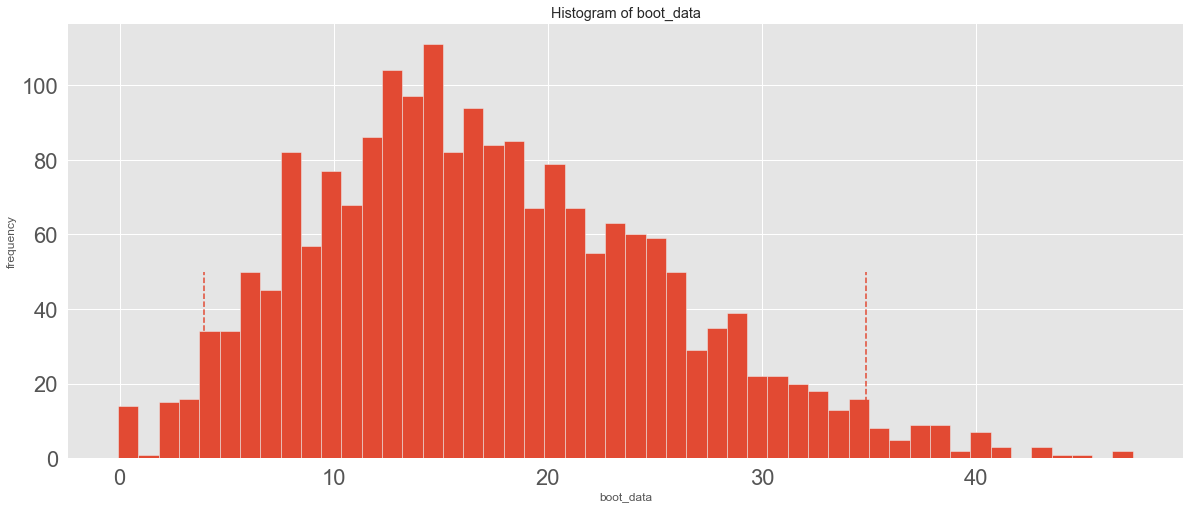

In [34]:
#Функция по умолчанию считает среднее по подвыборкам, поэтому опускаем этот аргумент
booted_result_mean = get_bootstrap(df_test.value, df_control.value, boot_it = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

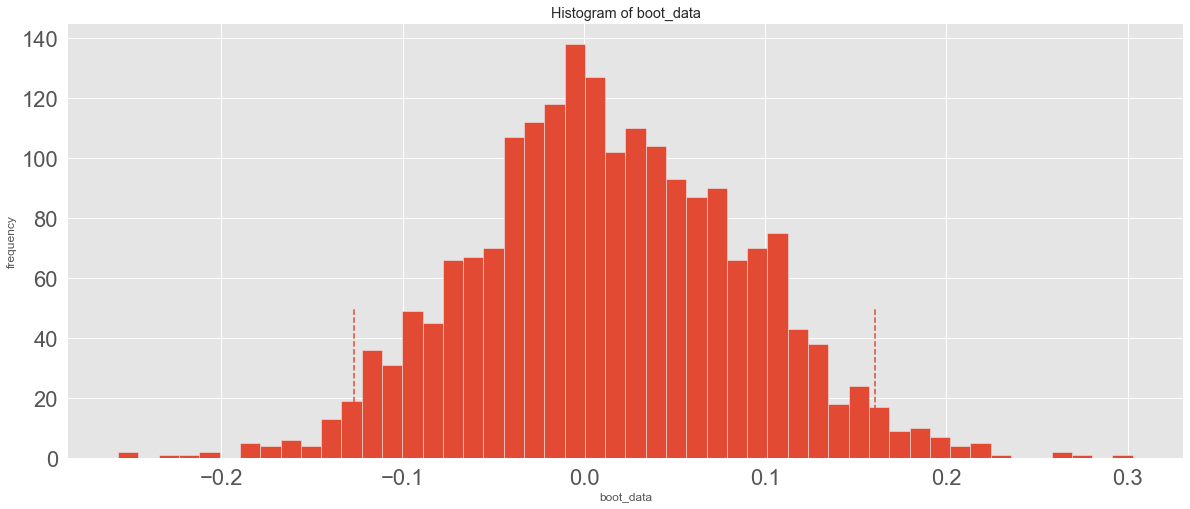

In [40]:
booted_result_median = get_bootstrap(df_test.value, df_control.value, boot_it = 2000,statistic = np.median)

In [44]:
booted_result_mean['p_value']


0.03477858625164023

In [45]:
booted_result_median['p_value']

0.8580706447150158

При применении бутстрапа на основе среднего значения подвыборок получены статистически 
значимые различия между контрольной и тестовой группами. При использовании медианы подвыборок
таких различий не установлено.

In [46]:
#Применим критерий Манна-Уитни
u_result = mannwhitneyu(df_test.value, df_control.value)
u_result

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

In [1]:
#Применение критерия Манна-Уитни и бутстрапа на основе медианного значения подвыборок не выявило статистически значимых различий.
#В данном примере применение бутстрапа на основе средних не дало корректного результата так как среднее чувствительно к наличию
#выбросов в данных. По итогам тестирования принимаем решение об отсутствии статистически значимых отличий между группами.

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза

In [52]:
#Отфильтруем выбросы в тестовом датасете и убедимся, что при его сравнении с контрольным отсутствуют статистически значимые отличия
df_test_clean = boot_df.query('experimentVariant == "Treatment" & value < 1000 ')

  0%|          | 0/2000 [00:00<?, ?it/s]

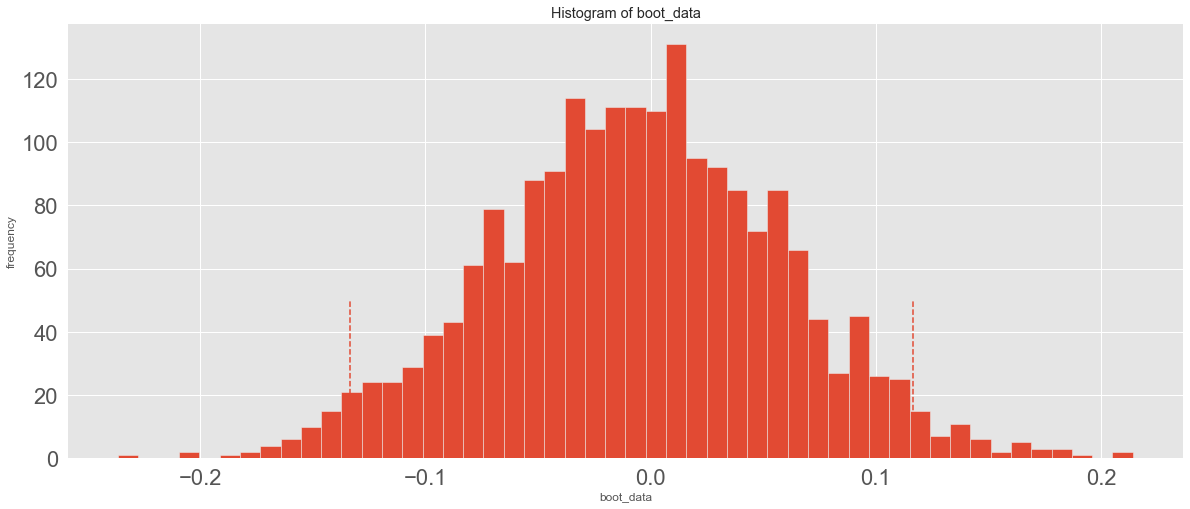

In [54]:
booted_result_mean_clean = get_bootstrap(df_test_clean.value, df_control.value, boot_it = 2000)

In [55]:
booted_result_mean_clean['p_value']

0.9257152029554283

На отфильтрованных данных бутстрап также показывает отсутствие статистически значимых различий между средними